In [38]:
# This code downloads precipitation or river discharge data from SMHI's OpenData API 
# Author: Marlon Passos
# Adapted from Kristoffer Bäckman https://github.com/thebackman/SMHI

In [6]:
# Hydrological Observations (for river discharge)
ADR_VERSION   = "http://opendata-download-hydroobs.smhi.se/api/version/1.0.json"
ADR_PARAMETER = "http://opendata-download-hydroobs.smhi.se/api/version/1.0/parameter/{parameter}.json" 
ADR_STATION = "http://opendata-download-hydroobs.smhi.se/api/version/1.0/parameter/{parameter}/station/{station}.json"
ADR_LATEST_MONTHS = "http://opendata-download-hydroobs.smhi.se/api/version/1.0/parameter/{parameter}/station/{station}/period/latest-months/data.json"
ADR_CORRECTED = "http://opendata-download-hydroobs.smhi.se/api/version/1.0/parameter/{parameter}/station/{station}/period/corrected-archive/data.csv"

In [ ]:
# Meteorological Observations (for precipitation)
ADR_VERSION   = "http://opendata-download-metobs.smhi.se/api/version/1.0.json"
ADR_PARAMETER = "http://opendata-download-metobs.smhi.se/api/version/1.0/parameter/{parameter}.json" 
ADR_STATION = "http://opendata-download-metobs.smhi.se/api/version/1.0/parameter/{parameter}/station/{station}.json"
ADR_LATEST_MONTHS = "http://opendata-download-metobs.smhi.se/api/version/1.0/parameter/{parameter}/station/{station}/period/latest-months/data.json"
ADR_LATEST_DAY = "http://opendata-download-metobs.smhi.se/api/version/1.0/parameter/{parameter}/station/{station}/period/latest-day/data.json"
ADR_CORRECTED = "http://opendata-download-metobs.smhi.se/api/version/1.0/parameter/{parameter}/station/{station}/period/corrected-archive/data.csv"

In [7]:
import datetime
import sys
import logging
import json
import requests

# -- logging

FORMAT = '%(asctime)s %(levelname)s: %(module)s: %(funcName)s(): %(message)s'
logging.basicConfig(level=logging.DEBUG, format = FORMAT, filename = "smhi.log", filemode = "w")
logging.getLogger("requests").setLevel(logging.WARNING)
logging.getLogger("urllib3").setLevel(logging.WARNING)

# -- functions

def write_json(json_obj, file_name = 'file.json'):
    """ write a json file to wd/file.json"""
    with open(file_name, 'w') as outfile:
        json.dump(json_obj, outfile)

def api_return_data(adr):
    """ initate API call and return the JSON data """
    # initiate the call
    req_obj = requests.get(adr)
    # try to get the json data (exceptions will be catched later)
    json_data = req_obj.json()
    return json_data

In [8]:
import datetime
import sys
import logging
import json
import requests

# -- logging

FORMAT = '%(asctime)s %(levelname)s: %(module)s: %(funcName)s(): %(message)s'
logging.basicConfig(level=logging.DEBUG, format = FORMAT, filename = "smhi.log", filemode = "w")
logging.getLogger("requests").setLevel(logging.WARNING)
logging.getLogger("urllib3").setLevel(logging.WARNING)

# -- functions

def write_json(json_obj, file_name = 'file.json'):
    """ write a json file to wd/file.json"""
    with open(file_name, 'w') as outfile:
        json.dump(json_obj, outfile)

def api_return_data(adr):
    """ initate API call and return the JSON data """
    # initiate the call
    req_obj = requests.get(adr)
    # try to get the json data (exceptions will be catched later)
    json_data = req_obj.json()
    return json_data
    

In [9]:
#import api_endpoints
#import helpers
import requests
import pandas as pd
import json
import logging

# -- functions

def list_params():
    """ Lists avaliable parameters """

    # -- API call

    data_json = api_return_data(ADR_VERSION)

    # -- print collected data

    # subset and loop over all avaliable parameters
    resource = data_json["resource"]
    # loop over the json entries and print each parameter that is avaliable

    # store all param keys in a dict for later use (maybe)
    params = []
    for param in resource:
        print(param["title"] + " | " +  param["summary"] + " | " + param["key"] )
        params.append(param["key"])
    # return params


def list_stations(param):
    """ list stations that have a certain wheather parameter """

    # -- API call
    
    # create the API adress
    adr = ADR_PARAMETER
    adr_full = adr.format(parameter = param)

    # send request and get data
    data1 = api_return_data(adr_full)
    print("Parameter choosen: " + data1["title"])

    # -- gather and wrangle the data about avaliable stations
    
    # take out an array with all the stations
    stations = data1["station"]
    
    # convert the JSON data to a pandas DF
    df_raw = pd.DataFrame(stations)
    
    # limit the data frame
    df_clean = df_raw[["name", "id", "latitude", "longitude", "active", "from", "to", "updated", "title", "key"]]
    
    # rename columns to abide to python reserved keywords
    df_clean = df_clean.rename(columns={"from": "starting", "to": "ending"})
    
    # fix the date and time variables into something readable
    tmp1 = pd.to_datetime(df_clean["starting"], unit = "ms")
    tmp2 = pd.to_datetime(df_clean["ending"], unit = "ms")
    tmp3 = pd.to_datetime(df_clean["updated"], unit = "ms")
    df_clean = df_clean.assign(starting = tmp1)
    df_clean = df_clean.assign(ending = tmp2)
    df_clean = df_clean.assign(updated = tmp3)
    
    return(df_clean)


def get_latest_months(param, station):
    """
    get data for latest months via JSON download """

    # -- API call
    
    # create the API adress
    adr = ADR_LATEST_MONTHS
    adr_full = adr.format(parameter = param, station = station)
    
    # send request and get data
    data1 = api_return_data(adr_full)
    
    # create a data frame from the JSON data
    df = pd.DataFrame(data1["value"])

    # fix the timestamps
    df = df.rename(columns={"from": "starting", "to": "ending"})
    tmp1 = pd.to_datetime(df["starting"], unit = "ms")
    tmp2 = pd.to_datetime(df["ending"], unit = "ms")
    df = df.assign(starting = tmp1)
    df = df.assign(ending = tmp2)

    # convert value to float64
    df["value"] = df.value.astype(float)

    # add the station id
    df["station_id"] = station
    
    return df


def get_corrected(param, station):
    """ get corrected archive via CSV download """
    # -- API call

    # create the API adress
    adr = ADR_CORRECTED
    adr_full = adr.format(parameter = param, station = station)

    # download the csv data
    df = pd.read_csv(filepath_or_buffer= adr_full, skiprows= 7, delimiter=";")

    # remove columns not needed and reorder to match latest months data
    df_lim = df.iloc[:,[0, 1, 2, 5]]

    # rename the columns
    df_lim.columns = ["date", "value", "quality", "ref"]

    # fix datetime columns
    df_lim["date"] = pd.to_datetime(df_lim["date"])

    # add the station id
    df_lim["station_id"] = station

    return df_lim


def get_stations(param, station_keys):
    """
    gets both latest months and corrected archive for
    a set of stations. Contains the try catch logic needed
    if any of the calls fail
    """

    # -- create the iterable

    if isinstance(station_keys, tuple):
        iterable = station_keys
    elif isinstance(station_keys, pd.DataFrame):
        iterable = station_keys["key"]
    
    # -- Construct some holder structures for data frames

    df_new = dict()
    df_old = dict()
    
    # -- loop through set of stations
    
    # start loop over each station id and collect the data if avaliable
    print(">>> Start downloading each station")
    for station_id in iterable:
        print(f">>> Downloading {station_id}")
        #logging.info(f"# -- Downloading station {station_id}")
        # get the latest months
       # logging.info(f"Downloading latest months for {station_id}")
       # try:
            #df_new[station_id] = get_latest_months(param = param, station = station_id )
           # logging.debug(f"downloading latest months for {station_id} successful")
       # except: #json.decoder.JSONDecodeError:
            #logging.error(f"not possible to download latest months for {station_id}")
        # get the corrected archive
        logging.info(f"downloading corrected archive for {station_id}")
        try:
            df_old[station_id] = get_corrected(param = param, station = station_id)
            logging.debug(f"downloaded corrected archive for {station_id} successful")
        except Exception as error:
            logging.error(f"not possible to download corrected archive for {station_id}")
    
    # -- gather the data

    # get the number of data frames in each dict
    len_new = len(df_new)
    len_old = len(df_old)

    # Stack the latest months into one data frame for each station
    if len_new > 0:
        df_latest = pd.concat(df_new.values(), ignore_index=True)
    else:
        df_latest = None

    # Stack the corrected archive into one data frame for each station
    if len_old > 0:
        df_corrected = pd.concat(df_old.values(), ignore_index=True)
    else:
        df_corrected = None

    # return all data
    print("Check smhi.log for data download details!")
    if df_latest is not None and df_corrected is not None :
        logging.debug("both df_latest and df_corrected contains data")
        dictus = {"df_latest": df_latest, "df_corrected": df_corrected}
    elif df_latest is not None:
        logging.info("only df_latest contain data")
        dictus = {"df_latest": df_latest}
    elif df_corrected is not None:
        logging.info("only df_corrected contain data")
        dictus = {"df_corrected": df_corrected}
    else:
        logging.info("no data frame contains data")
        dictus = None
    
    # -- shutdown logging

    logging.shutdown()
    
    return(dictus)

In [10]:

# -- import the libs and some reload 

import pandas as pd
#import smhi as smhi
#import importlib
#importlib.reload(smhi)

# -- listing the parameters that are avaliable

params=list_params()

# -- for one parameter, see what stations have it and in what timeframe, lon lat area etc.

# all stations 
df_stations = list_stations(param = 1)

# list one station
#df_stations.loc[df_stations["key"] == "159880"]

# limit the stations further to those that have been online in recent years
#df_stations = df_stations.loc[(df_stations["starting"] >= '2000-01-01')]

# take a random sample of stations
#df_random = df_stations.sample(n = 10, random_state= 11)
#df_random

# TODO:

# limit the stations to within a geographical area
# fix the order of data frame columns so that they match
# add some examples and actually do something with the data


# -- get the actual data

# create a tuple to try out stations
# 97250: not active, no latest months data, only historical
# 158820: active, both latest months and historical data

#station = (2506,)
#station = 2506
#station = (158820,)
station = (2506, 2372)

# download for station(s)
dict_df = get_stations(param = 1, station_keys = station)

# access the data
#dict_df["df_latest"]
dict_df["df_corrected"]

Vattenföring | Description | 1
Parameter choosen: Vattenföring: Välj station (sedan tidsutsnitt)
>>> Start downloading each station
>>> Downloading 2506
>>> Downloading 2372


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["station_id"] = station
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

Check smhi.log for data download details!


,date,value,quality,ref,station_id
0,2004-01-01,8.9175,G,Tidsperiod (t.o.m.) = 2023-03-15 11:59:59 (UTC),2506
1,2004-01-02,8.9376,G,NaN,2506
2,2004-01-03,8.9708,G,"Ett dygnsvärde mäts enligt svensk sommartid, d...",2506
3,2004-01-04,8.8499,G,NaN,2506
4,2004-01-05,8.8214,G,Kvalitetskoderna:,2506
...,...,...,...,...,...
20699,2023-03-11,12.4085,O,NaN,2372
20700,2023-03-12,12.2662,O,NaN,2372
20701,2023-03-13,12.9126,O,NaN,2372
20702,2023-03-14,18.7519,O,NaN,2372


In [11]:
df_stations.sort_values('starting')

,name,id,latitude,longitude,active,starting,ending,updated,title,key
587,ÖVRE HYNDEVAD,138,59.3221,16.4659,True,1888-12-31 22:00:00,2023-03-13 22:00:00,2023-03-13 22:00:00,Vattenföring - ÖVRE HYNDEVAD,138
230,KLIPPAN,191,56.1431,13.1114,False,1889-12-31 22:00:00,1926-12-30 22:00:00,1926-12-30 22:00:00,Vattenföring - KLIPPAN,191
436,SOLVEDEN,887,57.8754,12.4423,True,1897-12-31 22:00:00,2023-03-15 22:00:00,2023-03-15 11:59:59,Vattenföring - SOLVEDEN,887
588,ÖVRE LAHOLM,222,56.5147,13.0565,False,1898-12-31 22:00:00,1917-12-30 22:00:00,1917-12-30 22:00:00,Vattenföring - ÖVRE LAHOLM,222
272,LEKSAND 2,896,60.7292,14.9991,False,1899-12-31 22:00:00,1925-12-31 00:00:00,1925-12-31 00:00:00,Vattenföring - LEKSAND 2,896
...,...,...,...,...,...,...,...,...,...,...
422,SKÄLLNORA ÖVRE,2610,59.4850,17.9808,True,2017-12-18 22:00:00,2023-03-16 22:00:00,2023-03-16 11:45:00,Vattenföring - SKÄLLNORA ÖVRE,2610
504,TOLVFORS KRV,1940,60.6794,17.1122,True,2018-03-19 09:45:00,2023-03-16 13:00:00,2023-03-16 13:00:00,Vattenföring - TOLVFORS KRV,1940
165,HESTRAVIKEN,2606,57.4185,13.6284,True,2019-03-05 22:00:00,2023-03-16 22:00:00,2023-03-16 15:00:00,Vattenföring - HESTRAVIKEN,2606
84,EMSFORS,20002,57.1431,16.4513,True,2019-12-31 22:00:00,2023-03-16 15:30:00,2023-03-16 15:00:00,Vattenföring - EMSFORS,20002


In [12]:
import numpy as np
df_stations['duration']=df_stations['ending']-df_stations['starting']
df_stations['duration']=df_stations['duration']/ np.timedelta64(1, 'Y') # Convert from days to years
df_stations.sort_values(by='duration',ascending=False).head(30)

,name,id,latitude,longitude,active,starting,ending,updated,title,key,duration
587,ÖVRE HYNDEVAD,138,59.3221,16.4659,True,1888-12-31 22:00:00,2023-03-13 22:00:00,2023-03-13 22:00:00,Vattenföring - ÖVRE HYNDEVAD,138,134.195774
436,SOLVEDEN,887,57.8754,12.4423,True,1897-12-31 22:00:00,2023-03-15 22:00:00,2023-03-15 11:59:59,Vattenföring - SOLVEDEN,887,125.201750
337,NIEMISEL,20,66.0216,21.9672,True,1899-12-31 22:00:00,2023-03-16 22:00:00,2023-03-16 15:00:00,Vattenföring - NIEMISEL,20,123.205815
321,MÄLAREN,20040,59.3284,18.0664,True,1900-12-31 22:00:00,2023-02-27 22:00:00,2023-02-27 22:00:00,Vattenföring - MÄLAREN,20040,122.159935
395,RÖRVIK,200,57.2414,14.5883,True,1906-12-31 22:00:00,2023-03-16 22:00:00,2023-03-16 15:00:00,Vattenföring - RÖRVIK,200,116.207725
19,BALLASTVIKEN,40,66.4604,16.5778,False,1901-12-31 22:00:00,2017-04-16 22:00:00,2017-04-16 22:00:00,Vattenföring - BALLASTVIKEN,40,115.293264
317,MUNKEDAL 2,257,58.4643,11.6839,True,1907-12-31 22:00:00,2023-03-16 22:00:00,2023-03-16 15:00:00,Vattenföring - MUNKEDAL 2,257,115.208389
130,GIMDALSBY,97,62.8412,15.6619,True,1909-12-30 22:00:00,2023-03-16 22:00:00,2023-03-16 07:00:00,Vattenföring - GIMDALSBY,97,113.209717
325,MÖRRUM,186,56.1944,14.7491,True,1909-12-31 22:00:00,2023-03-16 22:00:00,2023-03-16 15:00:00,Vattenföring - MÖRRUM,186,113.206979
244,KUKKOLANKOSKI ÖVRE,16722,66.0307,24.0211,True,1910-12-31 22:00:00,2023-03-14 22:00:00,2023-03-14 22:00:00,Vattenföring - KUKKOLANKOSKI ÖVRE,16722,112.202167


In [85]:
#df_stations.to_excel('discharge_stations.xlsx')

In [36]:
import pandas as pd
df_stations= pd.read_excel('discharge_stations.xlsx')

In [49]:
df_stations= pd.read_excel('rain_stations.xlsx')

In [39]:
df_stations

,Unnamed: 0,name,id,latitude,longitude,active,starting,ending,updated,title,key,duration
574,574,ÅKESTA KVARN 2,2771,59.6730,16.4692,True,2021-11-01 22:00:00,2023-03-16 22:00:00,2023-03-16 00:00:00,Vattenföring - ÅKESTA KVARN 2,2771,1.368954
483,483,Stäholmsbäcken VM,90026,59.4935,16.0724,False,2010-10-12 14:30:00,2012-06-19 05:30:00,2012-06-20 22:00:00,Vattenföring - Stäholmsbäcken VM,90026,1.685524
61,61,Bramseröd VM,90021,58.7528,11.3794,False,2010-06-30 22:00:00,2012-04-22 22:00:00,2012-04-22 22:00:00,Vattenföring - Bramseröd VM,90021,1.812494
209,209,Jönåkers idrottsplats VM,90015,58.7401,16.7161,False,2009-11-11 22:00:00,2011-10-17 22:00:00,2011-10-17 22:00:00,Vattenföring - Jönåkers idrottsplats VM,90015,1.930224
289,289,Laxå VM,90073,58.9779,14.6352,False,2013-11-08 09:15:00,2015-10-28 08:15:00,2015-10-26 22:00:00,Vattenföring - Laxå VM,90073,1.968441
...,...,...,...,...,...,...,...,...,...,...,...,...
395,395,RÖRVIK,200,57.2414,14.5883,True,1906-12-31 22:00:00,2023-03-16 22:00:00,2023-03-16 15:00:00,Vattenföring - RÖRVIK,200,116.207725
321,321,MÄLAREN,20040,59.3284,18.0664,True,1900-12-31 22:00:00,2023-02-27 22:00:00,2023-02-27 22:00:00,Vattenföring - MÄLAREN,20040,122.159935
337,337,NIEMISEL,20,66.0216,21.9672,True,22:00:00,2023-03-16 22:00:00,2023-03-16 15:00:00,Vattenföring - NIEMISEL,20,123.205815
436,436,SOLVEDEN,887,57.8754,12.4423,True,1897-12-30 22:00:00,2023-03-15 22:00:00,2023-03-15 11:59:59,Vattenföring - SOLVEDEN,887,125.201750


In [44]:
import pandas as pd

# Convert strings to datetime
df_stations['starting'] = pd.to_datetime(df_stations['starting'], errors='coerce')

# Filter your DataFrame using datetime comparison
start_date_str = '1922-01-01 00:00:00'
start_date = pd.to_datetime(start_date_str)

filtered_df = df_stations[df_stations['starting'] > start_date]

# Now you can use the filtered_df for plotting


C:\Users\MarlonVieiraPassos\anaconda3\lib\site-packages\cartopy\crs.py:825: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
C:\Users\MarlonVieiraPassos\anaconda3\lib\site-packages\cartopy\crs.py:877: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
C:\Users\MarlonVieiraPassos\anaconda3\lib\site-packages\cartopy\crs.py:944: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


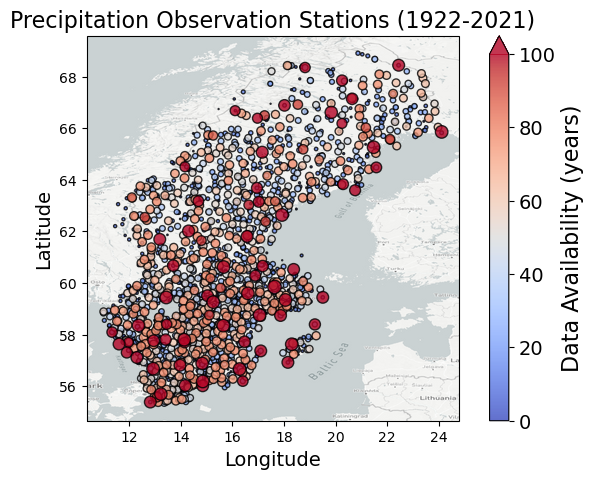

In [50]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.img_tiles as cimgt
from cartopy.io.shapereader import Reader
import numpy as np
import matplotlib
import matplotlib.colors as mcolors

# Sort your DataFrame
df_stations = df_stations.sort_values(by='duration')

plt.figure(figsize=(8, 5))

# Creates the map
sw_map = plt.axes(projection=ccrs.PlateCarree())

# To add county lines
mypath = r'C:\Users\MarlonVieiraPassos\OneDrive - SEI\Documents\HydroHazards\Codes\OSM\halmstad\data\shapefiles\\'
data = Reader(mypath + 'se_10km.shp')
sw_border = list(data.geometries())
sw_border2 = cfeature.ShapelyFeature(sw_border, ccrs.PlateCarree())
sw_map.add_feature(sw_border2, facecolor='none', edgecolor='gray')

request = cimgt.MapboxTiles(map_id='light-v10',access_token="pk.eyJ1IjoibXZwYXNzb3MiLCJhIjoiY2t6em4xcnpwMGJ2bDNicDYyemM0bWU4YyJ9.fR55BgEafulrz4yLfY2oRA")
sw_map.add_image(request, 5, cmap='gray', interpolation='spline36', regrid_shape=2000)

sw_map.xaxis.set_visible(True)
sw_map.yaxis.set_visible(True)

# Plots the data onto map
cmap = matplotlib.cm.coolwarm
norm = matplotlib.colors.Normalize(vmin=0, vmax=100)

plt.scatter(df_stations['longitude'], df_stations['latitude'], alpha=0.8,
            s=df_stations['duration'] / 2,
            c=df_stations['duration'],
            edgecolors='black',
            cmap=cmap,
            norm=norm,  # Apply the normalization to the scatter plot
            transform=ccrs.PlateCarree())

# Colorbar
cbar = plt.colorbar(extend='max')
cbar.set_label('Data Availability (years)', fontsize=16)
cbar.ax.tick_params(labelsize=14)
# Plot labels
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)
plt.title('Precipitation Observation Stations (1922-2021)', fontsize=16)

plt.savefig('precipitation_stations_smhi2.png', format="png", dpi=120)
plt.show()


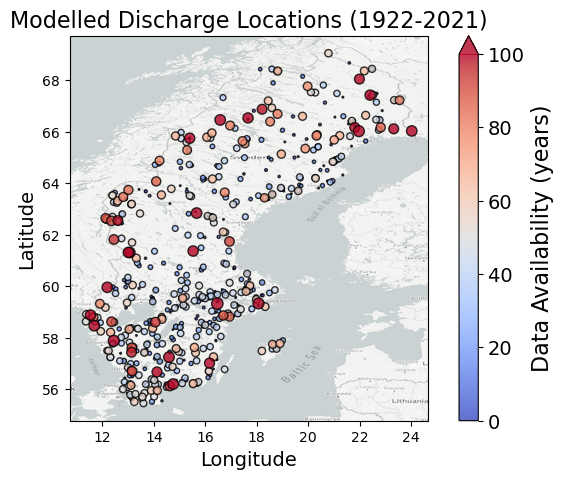

In [48]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.img_tiles as cimgt
from cartopy.io.shapereader import Reader
import numpy as np
import matplotlib
import matplotlib.colors as mcolors

# Sort your DataFrame
df_stations = df_stations.sort_values(by='duration')

plt.figure(figsize=(8, 5))

# Creates the map
sw_map = plt.axes(projection=ccrs.PlateCarree())

# To add county lines
mypath = r'C:\Users\MarlonVieiraPassos\OneDrive - SEI\Documents\HydroHazards\Codes\OSM\halmstad\data\shapefiles\\'
data = Reader(mypath + 'se_10km.shp')
sw_border = list(data.geometries())
sw_border2 = cfeature.ShapelyFeature(sw_border, ccrs.PlateCarree())
sw_map.add_feature(sw_border2, facecolor='none', edgecolor='gray')

request = cimgt.MapboxTiles(map_id='light-v10',access_token="pk.eyJ1IjoibXZwYXNzb3MiLCJhIjoiY2t6em4xcnpwMGJ2bDNicDYyemM0bWU4YyJ9.fR55BgEafulrz4yLfY2oRA")
sw_map.add_image(request, 5, cmap='gray', interpolation='spline36', regrid_shape=2000)

sw_map.xaxis.set_visible(True)
sw_map.yaxis.set_visible(True)

# Plots the data onto map
cmap = matplotlib.cm.coolwarm
norm = matplotlib.colors.Normalize(vmin=0, vmax=100)

plt.scatter(df_stations['longitude'], df_stations['latitude'], alpha=0.8,
            s=df_stations['duration'] / 2,
            c=df_stations['duration'],
            edgecolors='black',
            cmap=cmap,
            norm=norm,  # Apply the normalization to the scatter plot
            transform=ccrs.PlateCarree())

# Colorbar
cbar = plt.colorbar(extend='max')
cbar.set_label('Data Availability (years)', fontsize=16)
cbar.ax.tick_params(labelsize=14)
# Plot labels
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)
plt.title('Modelled Discharge Locations (1922-2021)', fontsize=16)

plt.savefig('discharge_stations_smhi2.png', format="png", dpi=120)
plt.show()


In [13]:
# Download data for all stations (monthly/daily rainfall)
pnumber = 1 # 23: monthly rainfall, 5: daily rainfall
df_all=pd.DataFrame()
id_list=df_stations['id'].unique()
for station_id in id_list:
    try:
        sid = (station_id,)
        dict_df = get_stations(param = pnumber, station_keys = sid) 
        df_all=df_all.append(dict_df["df_corrected"])
    except:
        pass

C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["station_id"] = station


>>> Start downloading each station
>>> Downloading 2357
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 2000


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 2364
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 1242
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 2231


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["station_id"] = station
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ve

Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 2356
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 1239
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 1537


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["station_id"] = station
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ve

Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 2311
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 1881


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["station_id"] = station
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ve

Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 1166
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 2371


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["station_id"] = station
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ve

Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 90039
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 1374
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 828


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["station_id"] = station
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ve

Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 622
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 1432
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 1566


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["station_id"] = station
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ve

Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 2250
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 40
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

>>> Start downloading each station
>>> Downloading 2316
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 2218
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 960


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["station_id"] = station
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ve

Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 1266
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 1111
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 44
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

>>> Start downloading each station
>>> Downloading 2300
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 1573
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 2145


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["station_id"] = station
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ve

Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 2251
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 981
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 1091


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["station_id"] = station
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ve

Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 1836
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 446
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 2376


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["station_id"] = station
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ve

Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 1184
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 1257
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 2318


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 1129
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 888
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 1240
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

>>> Start downloading each station
>>> Downloading 725
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 2033


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 727
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 292
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 2211


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["station_id"] = station
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ve

Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 840
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 746
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 198
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

>>> Start downloading each station
>>> Downloading 1622
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 2189


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["station_id"] = station
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ve

Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 2127
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 877


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["station_id"] = station
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ve

Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 2151
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 2227


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["station_id"] = station
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ve

Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 2284
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 90007
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 90042


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["station_id"] = station
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html

Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 90067
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 90011
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 90006


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["station_id"] = station
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ve

Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 90021
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 90062
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 739
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 2334


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["station_id"] = station
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ve

Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 2396
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 90024
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 2439


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["station_id"] = station
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ve

Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 2020
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 2444


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["station_id"] = station
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ve

Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 2206
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 2409


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 2335
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 462
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

>>> Start downloading each station
>>> Downloading 1302
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 2142


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["station_id"] = station
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ve

Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 90008
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 90054
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 2219


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 274
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 2213


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["station_id"] = station
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ve

Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 1149
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 1206
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 2126


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["station_id"] = station
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ve

Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 20002
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 654


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 90012
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 699
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 1015
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 2148


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["station_id"] = station
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ve

Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 2205
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 1858
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 2241


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["station_id"] = station
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ve

Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 2242
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 2429


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["station_id"] = station
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ve

Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 1183


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["station_id"] = station
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ve

Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 10
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 1375


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["station_id"] = station
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ve

Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 1256
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 2611
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 291


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 1210
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 1619


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 71
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 2372


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 69
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 948


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["station_id"] = station
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ve

Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 842
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 2362


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["station_id"] = station
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ve

Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 437
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 1636


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["station_id"] = station
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ve

Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 2370
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 2344
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 655


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["station_id"] = station
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ve

Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 997
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 1082


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["station_id"] = station
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ve

Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 1179
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 2117


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 90029
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 429
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

>>> Start downloading each station
>>> Downloading 1530
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 1584
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

>>> Start downloading each station
>>> Downloading 923
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 958
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 1425


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["station_id"] = station
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ve

Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 1831
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 2443


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["station_id"] = station
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ve

Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 1630
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 855


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 1099
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 97


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["station_id"] = station
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ve

Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 962
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 1197
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

>>> Start downloading each station
>>> Downloading 1259
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 1387


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["station_id"] = station
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ve

Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 2239
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 2605
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

>>> Start downloading each station
>>> Downloading 195
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 935
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 2237


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 2309
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 2188


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["station_id"] = station
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ve

Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 2319
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 2217


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["station_id"] = station
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ve

Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 2348
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 1171


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["station_id"] = station
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ve

Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 2332
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 2122


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["station_id"] = station
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ve

Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 90072
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 90080
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 90047


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["station_id"] = station
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ve

Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 815
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 1207


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["station_id"] = station
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ve

Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 2328
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 2146


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["station_id"] = station
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ve

Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 1273


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["station_id"] = station
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ve

Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 937
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 1243


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["station_id"] = station
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ve

Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 139
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

>>> Start downloading each station
>>> Downloading 2153
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 75


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["station_id"] = station
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ve

Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 2273
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 1590


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 2614
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 1586


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["station_id"] = station
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ve

Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 2606
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 2128


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 2413
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 364


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["station_id"] = station
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ve

Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 2445
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 2596


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["station_id"] = station
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ve

Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 1909
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 720


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 2154
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 2305


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["station_id"] = station
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ve

Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 2410
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 90052
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

>>> Start downloading each station
>>> Downloading 90050
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 90010
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 1033


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["station_id"] = station
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ve

Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 2312
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 2331


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["station_id"] = station
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ve

Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 444
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["station_id"] = station
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ve

>>> Start downloading each station
>>> Downloading 2422
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 2248


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["station_id"] = station
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ve

Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 2030
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 20044


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["station_id"] = station
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ve

Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 736


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["station_id"] = station
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ve

Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 2171
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 187


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["station_id"] = station
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ve

Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 2144
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 2365


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 90066
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 1706


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["station_id"] = station
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ve

Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 2258
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 2617


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["station_id"] = station
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ve

Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 728
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 90055
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

>>> Start downloading each station
>>> Downloading 166
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 224


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["station_id"] = station
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ve

Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 747
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 3


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["station_id"] = station
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ve

Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 51
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 4


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["station_id"] = station
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ve

Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 20005
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 20008
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

>>> Start downloading each station
>>> Downloading 90069
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 866
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 177


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 90015
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 1456


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["station_id"] = station
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ve

Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 589
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

>>> Start downloading each station
>>> Downloading 2395
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 6


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["station_id"] = station
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ve

Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 1403


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["station_id"] = station
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ve

Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 1147
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 10006


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["station_id"] = station
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ve

Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 2139
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 55


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["station_id"] = station
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ve

Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 1918
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 2465


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["station_id"] = station
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ve

Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 7
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 2254


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 2595
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 974


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["station_id"] = station
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ve

Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 543
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 2159


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["station_id"] = station
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ve

Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 10008


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["station_id"] = station
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ve

Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 1685
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

>>> Start downloading each station
>>> Downloading 2116
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 191


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["station_id"] = station
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ve

Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 1635


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["station_id"] = station
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ve

Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 2597
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 1580


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["station_id"] = station
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ve

Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 178
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 1303


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 2240
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

>>> Start downloading each station
>>> Downloading 2229
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 2119


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["station_id"] = station
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ve

Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 2215
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 1919


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["station_id"] = station
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ve

Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 1133
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 570


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 1160


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["station_id"] = station
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ve

Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 16722


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["station_id"] = station
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ve

Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 2433
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 1433


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["station_id"] = station
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ve

Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 2310
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

>>> Start downloading each station
>>> Downloading 90063
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 90064
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 90014


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 1065
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 1962


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 704
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 1306


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 189
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 1790


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["station_id"] = station
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ve

Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 952
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["station_id"] = station


>>> Start downloading each station
>>> Downloading 2235
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 741


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 973
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 1480


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["station_id"] = station
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ve

Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 1697
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

>>> Start downloading each station
>>> Downloading 90033
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 2414
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["station_id"] = station
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ve

>>> Start downloading each station
>>> Downloading 2323
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 357


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["station_id"] = station
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ve

Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 1701


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["station_id"] = station
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ve

Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 5
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

>>> Start downloading each station
>>> Downloading 813
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 2158


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["station_id"] = station
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ve

Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 1815


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["station_id"] = station
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ve

Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 896
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 1764


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["station_id"] = station
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ve

Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 2437
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 1859


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["station_id"] = station
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ve

Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 1880
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 1920


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["station_id"] = station
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ve

Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 1083


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["station_id"] = station
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ve

Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 2283
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

>>> Start downloading each station
>>> Downloading 1762
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 1882


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 2336
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

>>> Start downloading each station
>>> Downloading 2007
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 1169


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["station_id"] = station
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ve

Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 1964
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 2619


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["station_id"] = station
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ve

Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 130
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 2245


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 90073
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 90002


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["station_id"] = station
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ve

Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 90070
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 816


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["station_id"] = station
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ve

Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 1066
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 74


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["station_id"] = station
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ve

Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 1690


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 2295
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 1054


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["station_id"] = station
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ve

Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 90053
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 10016


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 1071
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["station_id"] = station
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ve

>>> Start downloading each station
>>> Downloading 65
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 2400


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["station_id"] = station
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ve

Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 2406
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

>>> Start downloading each station
>>> Downloading 830
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 2152


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 2289
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

>>> Start downloading each station
>>> Downloading 2214
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 1101


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["station_id"] = station
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ve

Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 1780


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["station_id"] = station
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ve

Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 2255
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

>>> Start downloading each station
>>> Downloading 164
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 2276
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["station_id"] = station
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ve

>>> Start downloading each station
>>> Downloading 2203
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 1221


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 18
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["station_id"] = station


>>> Start downloading each station
>>> Downloading 1950
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 257


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["station_id"] = station
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ve

Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 729
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["station_id"] = station
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ve

>>> Start downloading each station
>>> Downloading 39
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 90034
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["station_id"] = station
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ve

>>> Start downloading each station
>>> Downloading 20040


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["station_id"] = station
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ve

Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 11


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["station_id"] = station
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ve

Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 994
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 1069


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["station_id"] = station
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ve

Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 186


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["station_id"] = station
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ve

Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 2013
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 10004


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["station_id"] = station
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ve

Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 2200


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["station_id"] = station
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ve

Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 959


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["station_id"] = station
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ve

Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 1674
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

>>> Start downloading each station
>>> Downloading 1109
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 2467


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["station_id"] = station
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ve

Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 703
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 148


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 2194
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["station_id"] = station


>>> Start downloading each station
>>> Downloading 591
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 20


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["station_id"] = station
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ve

Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 1085
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["station_id"] = station


>>> Start downloading each station
>>> Downloading 1901
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 1912


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 238
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

>>> Start downloading each station
>>> Downloading 2408
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 2202


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["station_id"] = station
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ve

Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 2360
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["station_id"] = station
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ve

>>> Start downloading each station
>>> Downloading 2621
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 2003


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["station_id"] = station
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ve

Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 2053


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["station_id"] = station
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ve

Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 740


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["station_id"] = station
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ve

Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 1019
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 67


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["station_id"] = station
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ve

Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 2256
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

>>> Start downloading each station
>>> Downloading 2330
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 61


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 90056
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 1053


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 2612
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 849


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["station_id"] = station
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ve

Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 181


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["station_id"] = station
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ve

Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 946
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["station_id"] = station
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ve

>>> Start downloading each station
>>> Downloading 1260
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 2221


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["station_id"] = station
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ve

Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 2399
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

>>> Start downloading each station
>>> Downloading 2304
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 1426


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 2234
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

>>> Start downloading each station
>>> Downloading 1336
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 90057


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 1271
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["station_id"] = station
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ve

>>> Start downloading each station
>>> Downloading 1315
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 2012


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["station_id"] = station
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ve

Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 1037
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["station_id"] = station


>>> Start downloading each station
>>> Downloading 2341
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 682


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 214
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["station_id"] = station
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ve

>>> Start downloading each station
>>> Downloading 29
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 90076
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["station_id"] = station
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ve

>>> Start downloading each station
>>> Downloading 2343
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 2123


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 2247
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

>>> Start downloading each station
>>> Downloading 1341
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

>>> Start downloading each station
>>> Downloading 2398
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 1122


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["station_id"] = station
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ve

Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 1159


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["station_id"] = station
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ve

Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 1204
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["station_id"] = station


>>> Start downloading each station
>>> Downloading 2417
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 2170


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 90013
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

>>> Start downloading each station
>>> Downloading 90041
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 17


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["station_id"] = station
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ve

Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 2207
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["station_id"] = station


>>> Start downloading each station
>>> Downloading 268
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 14


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 1559
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

>>> Start downloading each station
>>> Downloading 999
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 200


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["station_id"] = station
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ve

Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 1378


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["station_id"] = station
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ve

Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 90030
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["station_id"] = station


>>> Start downloading each station
>>> Downloading 998
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 925
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

>>> Start downloading each station
>>> Downloading 2405
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 2017


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 2402


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["station_id"] = station
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html

Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 348
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

>>> Start downloading each station
>>> Downloading 2253
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 2587


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 1058
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 1575


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["station_id"] = station
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ve

Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 978
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["station_id"] = station


>>> Start downloading each station
>>> Downloading 1675
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

>>> Start downloading each station
>>> Downloading 2333
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 2598


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["station_id"] = station
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ve

Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 1076
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

>>> Start downloading each station
>>> Downloading 1564
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 2155


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["station_id"] = station
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ve

Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 2275


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["station_id"] = station
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ve

Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 1394


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["station_id"] = station
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ve

Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 2404
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

>>> Start downloading each station
>>> Downloading 983
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 2337


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["station_id"] = station
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ve

Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 1022
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 1843


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["station_id"] = station
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ve

Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 2610
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["station_id"] = station


>>> Start downloading each station
>>> Downloading 2454
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 1756


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 1809


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["station_id"] = station
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ve

Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 2363
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["station_id"] = station


>>> Start downloading each station
>>> Downloading 439
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 440


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 2347


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["station_id"] = station
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ve

Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 2340
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

>>> Start downloading each station
>>> Downloading 436
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

>>> Start downloading each station
>>> Downloading 2608
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 1128


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["station_id"] = station
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ve

Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 2002
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

>>> Start downloading each station
>>> Downloading 2291
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 887


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 56


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["station_id"] = station
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ve

Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 2238


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["station_id"] = station
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ve

Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 2009
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["station_id"] = station


>>> Start downloading each station
>>> Downloading 2212
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 2143


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 1814
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

>>> Start downloading each station
>>> Downloading 1742
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

>>> Start downloading each station
>>> Downloading 2353
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 95


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 1096


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["station_id"] = station
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ve

Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 1878


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["station_id"] = station
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ve

Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 1235


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["station_id"] = station
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ve

Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 2342
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

>>> Start downloading each station
>>> Downloading 1743
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

>>> Start downloading each station
>>> Downloading 2361
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 37


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 1835


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["station_id"] = station
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ve

Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 834
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

>>> Start downloading each station
>>> Downloading 1910
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

>>> Start downloading each station
>>> Downloading 2767
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 1609


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 490


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["station_id"] = station
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ve

Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 2292


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["station_id"] = station
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ve

Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 2442
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["station_id"] = station


>>> Start downloading each station
>>> Downloading 2604
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 2607


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 1965
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

>>> Start downloading each station
>>> Downloading 1098
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 1274


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 1699
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

>>> Start downloading each station
>>> Downloading 1602
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 1236


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 528


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["station_id"] = station
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ve

Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 2359


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["station_id"] = station
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ve

Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 1126
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

>>> Start downloading each station
>>> Downloading 1879
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 1130


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 979


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 2407


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["station_id"] = station
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ve

Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 90075


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["station_id"] = station
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ve

Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 90009


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["station_id"] = station
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ve

Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 90040
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

>>> Start downloading each station
>>> Downloading 90004
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 90077


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 90048
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["station_id"] = station
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ve

>>> Start downloading each station
>>> Downloading 90023
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 90026
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["station_id"] = station
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ve

>>> Start downloading each station
>>> Downloading 90058
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 90079


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["station_id"] = station
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ve

Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 2616
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["station_id"] = station


>>> Start downloading each station
>>> Downloading 1061
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 1914


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 114


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["station_id"] = station
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ve

Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 1696


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["station_id"] = station
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ve

Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 1278
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

>>> Start downloading each station
>>> Downloading 690
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 2243


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 1877
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

>>> Start downloading each station
>>> Downloading 2432
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 1158


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 1185


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["station_id"] = station
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ve

Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 2220
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

>>> Start downloading each station
>>> Downloading 90003
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 2351


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["station_id"] = station
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ve

Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 1984
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

>>> Start downloading each station
>>> Downloading 27
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

>>> Start downloading each station
>>> Downloading 2293
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

>>> Start downloading each station
>>> Downloading 1940
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

>>> Start downloading each station
>>> Downloading 100
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

>>> Start downloading each station
>>> Downloading 1529
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

>>> Start downloading each station
>>> Downloading 2506
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 2525


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 742
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

>>> Start downloading each station
>>> Downloading 492
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 272


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 2138


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["station_id"] = station
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ve

Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 2768
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

>>> Start downloading each station
>>> Downloading 36
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

>>> Start downloading each station
>>> Downloading 2346
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 1407


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 2278


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["station_id"] = station
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ve

Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 90028
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["station_id"] = station
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ve

>>> Start downloading each station
>>> Downloading 90043
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 90059
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["station_id"] = station
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ve

>>> Start downloading each station
>>> Downloading 1673
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

>>> Start downloading each station
>>> Downloading 1223
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

>>> Start downloading each station
>>> Downloading 2358
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

>>> Start downloading each station
>>> Downloading 2299
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

>>> Start downloading each station
>>> Downloading 2129
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

>>> Start downloading each station
>>> Downloading 719
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

>>> Start downloading each station
>>> Downloading 1289
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 1639


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 90074
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["station_id"] = station


>>> Start downloading each station
>>> Downloading 244
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

>>> Start downloading each station
>>> Downloading 1222
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 2246


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 435


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["station_id"] = station
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ve

Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 2609
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

>>> Start downloading each station
>>> Downloading 1296
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

>>> Start downloading each station
>>> Downloading 910
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

>>> Start downloading each station
>>> Downloading 2618
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 2308


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["station_id"] = station
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ve

Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 2118


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["station_id"] = station
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ve

Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 737


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["station_id"] = station
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ve

Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 2345


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["station_id"] = station
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ve

Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 2252


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["station_id"] = station
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ve

Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 751


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["station_id"] = station
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ve

Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 1079


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["station_id"] = station
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ve

Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 563


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["station_id"] = station
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ve

Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 2244


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["station_id"] = station
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ve

Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 1294


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["station_id"] = station
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ve

Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 1662


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["station_id"] = station
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ve

Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 1913
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

>>> Start downloading each station
>>> Downloading 2018
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

>>> Start downloading each station
>>> Downloading 1295
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

>>> Start downloading each station
>>> Downloading 1623
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

>>> Start downloading each station
>>> Downloading 1963
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

>>> Start downloading each station
>>> Downloading 1041
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

>>> Start downloading each station
>>> Downloading 90068
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 90037


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 53
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

>>> Start downloading each station
>>> Downloading 197
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 2317


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 1583


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["station_id"] = station
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ve

Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 1209
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

>>> Start downloading each station
>>> Downloading 2397
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 1123


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["station_id"] = station
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ve

Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 2236


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["station_id"] = station
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ve

Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 2290


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["station_id"] = station
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ve

Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 1309


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["station_id"] = station
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ve

Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 38


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["station_id"] = station
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ve

Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 2325


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["station_id"] = station
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ve

Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 1208


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["station_id"] = station
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ve

Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 2196


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["station_id"] = station
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ve

Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 693
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

>>> Start downloading each station
>>> Downloading 2249
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

>>> Start downloading each station
>>> Downloading 2216
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

>>> Start downloading each station
>>> Downloading 2771
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 227


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 1640
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

>>> Start downloading each station
>>> Downloading 2201
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

>>> Start downloading each station
>>> Downloading 718
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

>>> Start downloading each station
>>> Downloading 2613
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 822


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 1258


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["station_id"] = station
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ve

Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 1985


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["station_id"] = station
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ve

Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 2147


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["station_id"] = station
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ve

Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 1328


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["station_id"] = station
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ve

Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 2329
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

>>> Start downloading each station
>>> Downloading 957
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 138


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["station_id"] = station
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ve

Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 222


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["station_id"] = station
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ve

Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 1740


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["station_id"] = station
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ve

Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 358


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["date"] = pd.to_datetime(df_lim["date"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\782788631.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lim["station_id"] = station


Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_18356\3470295444.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


In [14]:
import pandas as pd
#df_all.to_csv('discharge_data.csv')

In [15]:
#df_stations.to_excel('discharge_stations.xlsx')